In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import numpy as np
from parmed.topologyobjects import DihedralType
from simtk import unit
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db

Generate toy model that allows continuous phase proposals between 0 and 180 and decouples n

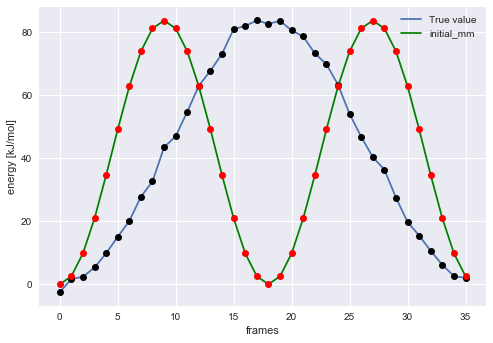

In [2]:
toy = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(10, 2, 180, 1, 1), 
               n_increments=18, sample_phase=True, continuous=True, rj=False)
plt.plot(toy.synthetic_energy, label='True value')
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='g', label='initial_mm')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')
plt.legend()

In [3]:
# sample
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='continuous.sqlite')
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 368.7 sec

In [5]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)
print(toy.model.pymc_parameters['CG331_CG321_CG321_CG331_1_K'].value)

true value
<DihedralTypes [<DihedralType; phi_k=10.000, per=1, phase=180.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralTypes [<DihedralType; phi_k=10.000, per=2, phase=180.000,  scee=1.000, scnb=1.000>]>
9.81899705321195


With continuous phase proposals torsionfit gives a good fit. 

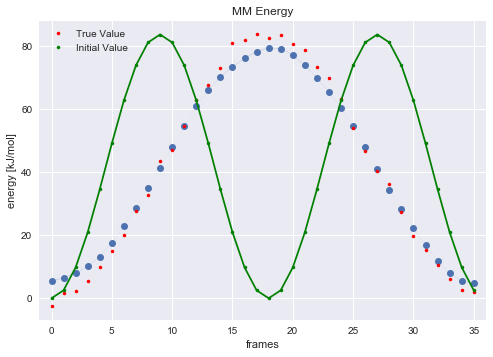

In [6]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, '.', color='r', label='True Value')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, '.', color='g', label='Initial Value')
plt.plot(toy.scan_set.initial_mm, color='g')

plt.legend()
plt.savefig('energy_fit_continous.pdf')

In [7]:
import pymbar.timeseries as ts
[t, g, N_eff] = ts.detectEquilibration(sampler.trace('sigma')[:])
print('Start of equilibrated data: {}'.format(t))

Start of equilibrated data: 1484


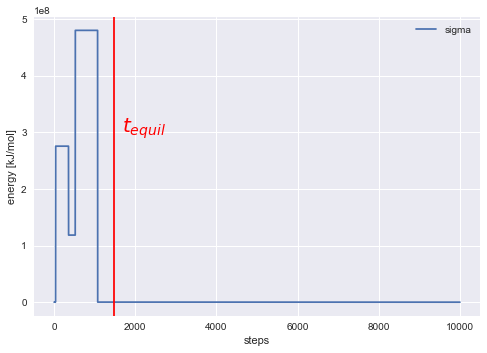

In [10]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.axvline(t, color='red')
plt.text(t+200, 300000000, r'$t_{equil}$', rotation=0, color='red', fontsize=20)
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.savefig('sigma_continous.pdf')

From the traces of each parameters, you can see how the phase slowly moves to 180 as multiplicity 1 truns on and 2 turns off 

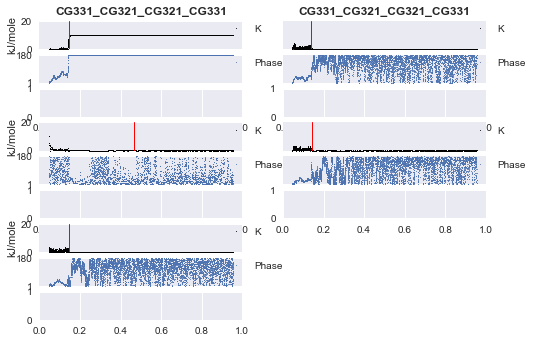

In [32]:
from torsionfit import plots
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0, continuous=True, multiplicity_traces=False, 
                 filename='traces_continuous.pdf')

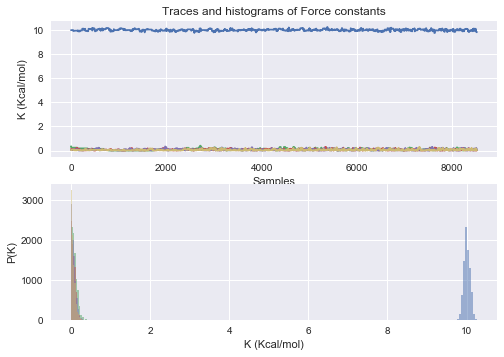

In [33]:
alpha=0.5
plt.subplot(2, 1, 1)
plt.title('Traces and histograms of Force constants')
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_1_K')[t:])
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_2_K')[t:])
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_3_K')[t:])
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_4_K')[t:])
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_6_K')[t:])
plt.ylabel('K (Kcal/mol)')
plt.xlabel('Samples')

plt.subplot(2, 1, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[t:], alpha=alpha)
plt.xlabel('K (Kcal/mol)')
plt.ylabel('P(K)')

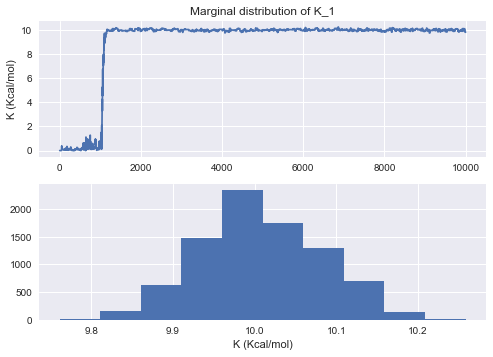

In [24]:
plt.subplot(2, 1, 1)
plt.title('Marginal distribution of K_1')
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_1_K')[:])
plt.ylabel('K (Kcal/mol)')
plt.subplot(2, 1, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[t:])
plt.xlabel('K (Kcal/mol)')

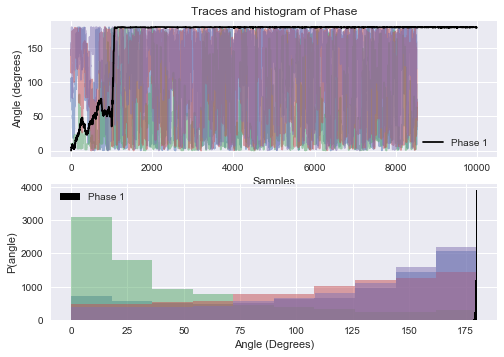

In [36]:
alpha=0.5
plt.subplot(2, 1, 1)
plt.title('Traces and histogram of Phase')
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_6_Phase')[t:], alpha=alpha)
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_2_Phase')[t:], alpha=alpha)
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_3_Phase')[t:], alpha=alpha)
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_4_Phase')[t:], alpha=alpha)
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_1_Phase')[:], color='black', label='Phase 1')
plt.ylabel('Angle (degrees)')
plt.xlabel('Samples')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_Phase')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_Phase')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_Phase')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_Phase')[t:], alpha=alpha)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_Phase')[t:], color='black', label='Phase 1')
plt.xlabel('Angle (Degrees)')
plt.ylabel('P(angle)')
plt.legend()

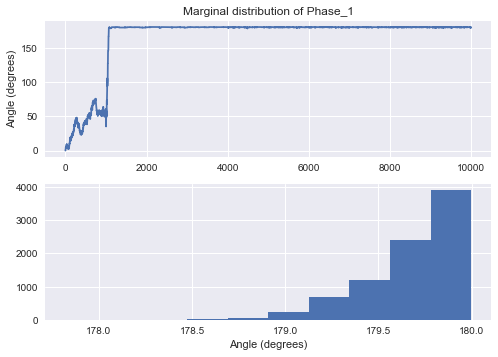

In [31]:
plt.subplot(2, 1, 1)
plt.title('Marginal distribution of Phase_1')
plt.plot(sampler.trace('CG331_CG321_CG321_CG331_1_Phase')[:])
plt.ylabel('Angle (degrees)')
plt.subplot(2, 1, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_Phase')[t:])
plt.xlabel('Angle (degrees)')